In [2]:
import numpy as np
import math
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from netCDF4 import Dataset

from sklearn.preprocessing import MinMaxScaler


import PCA_functions as pf
import Extreme_functions as ef


from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

import pickle
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
import Rung as rg
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [4]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -2
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

In [17]:
def min_MSE_finder(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]

    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        result.append(mean_squared_error(y_pred, y_test))
    return(result,link)


def min_MSE_finder1(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]
    refined_link = []
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_pred, y_test)
        if mse < result[-1]:
            result.append(mean_squared_error(y_pred, y_test))
            refined_link.append(link[z])
    return(result, np.array(refined_link))

In [18]:
name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc","../../nc/pres.mon.mean.nc","../../nc/air.mon.mean.nc","../../nc/sst.mnmean.nc"]
code = ["precip", "pres", "air", "sst"]
missing = [-9.96921e+36, -9.96921e+36, -9.96921e+36,-9.96921e+36]
n_components = [87, 64, 82, 76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]
               
    data = pd.DataFrame(result)

    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(scaled_data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)
    
pres_name  = []
for i in range(n_components[1]):
    pres_name.append("PRES_%d"%i)
    
sat_name  = []
for i in range(n_components[2]):
    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[3]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name + pres_name + sat_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))
result_precip = np.array(df_cluster[0])
result_pres = np.array(df_cluster[1])
result_sat = np.array(df_cluster[2])
result_sst = np.array(df_cluster[3])


result = np.concatenate((result_extremes,result_precip, result_pres, result_sat, result_sst), axis=1)
result = np.array(result)

KeyboardInterrupt: 

In [8]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()

In [9]:
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [7]:
#results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)

In [5]:
results = load_obj("results")

In [6]:
q_matrix = np.load("q_matrix.npy")

In [10]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 42 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.587
        (PRECIP_1 -1): pval = 0.00023 | val = 0.196
        (SAT_70 -1): pval = 0.00055 | val = 0.188
        (PRECIP_39 -1): pval = 0.00068 | val = 0.185
        (SAT_62 -1): pval = 0.00182 | val = -0.172
        (PRECIP_5 -1): pval = 0.00197 | val = 0.171
        (SST_60 -2): pval = 0.00210 | val = -0.168
        (PRECIP_49 -2): pval = 0.00280 | val = -0.165
        (PRES_29 -1): pval = 0.00375 | val = 0.158
        (PRECIP_13 -1): pval = 0.00508 | val = -0.155
        (PRES_32 -2): pval = 0.00491 | val = -0.154
        (PRES_32 -1): pval = 0.00492 | val = 0.154
        (PRECIP_11 -1): pval = 0.01009 | val = 0.142
        (PRECIP_78 -2): pval = 0.01073 | val = -0.142
        (SST_29 -1): pval = 0.01012 | val = -0.141
        (PRECIP_43 -2): pval = 0.01330 | val = -0.139
        (SST_41 -2): pval = 0.01254 | val = 0.138
        (PRES_46 -1): pval = 0.01

In [11]:
#q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.587

    Variable PRECIP_0 has 1 link(s):
        (SAT_7 -1): pval = 0.00002 | qval = 0.02883 | val = -0.236

    Variable PRECIP_1 has 0 link(s):

    Variable PRECIP_2 has 0 link(s):

    Variable PRECIP_3 has 0 link(s):

    Variable PRECIP_4 has 0 link(s):

    Variable PRECIP_5 has 0 link(s):

    Variable PRECIP_6 has 0 link(s):

    Variable PRECIP_7 has 0 link(s):

    Variable PRECIP_8 has 0 link(s):

    Variable PRECIP_9 has 0 link(s):

    Variable PRECIP_10 has 1 link(s):
        (PRECIP_60 -1): pval = 0.00001 | qval = 0.01316 | val = -0.242

    Variable PRECIP_11 has 0 link(s):

    Variable PRECIP_12 has 0 link(s):

    Variable PRECIP_13 has 0 link(s):

    Variable PRECIP_14 has 0 link(s):

    Variable PRECIP_15 has 0 link(s):

    Variable PRECIP_16 has 0 link(s):

    Variable PRECIP_17 has 1 link(s):
        (PRECIP_51 -

In [15]:
link = np.load()

In [19]:
name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = pf.deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)
    
    V, U, S, ts, eig, explained, max_comps = rg.pca_svd(data,truncate_by='max_comps', max_comps=n_components[0])

extremes_name  = ["n_extremes"]
sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((-1,1))
result_sst = np.array(ts)

In [7]:
name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = pf.deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(scaled_data)
    df_cluster.append(pca_model.transform(scaled_data))
    
  #  loading_sst = pf.varimax(np.transpose(pca_model.components_), q=1000)
  #  for z in range(loading_sst.shape[1]):
   #     loading_sst[:,z] = loading_sst[:,z] / np.linalg.norm(loading_sst[:,z])
        
   # loading_sst = np.transpose(pca_model.components_) 
   # loading_sst = pd.DataFrame(loading_sst)

    #df_cluster.append(np.matmul(np.array(data), np.array(loading_sst)))


    #df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


In [8]:
result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [9]:
results = load_obj("results_st")
q_matrix = np.load("q_matrix_sst.npy")

#results = load_obj("results_Cal_Rung")
#q_matrix = np.load("q_matrix_Cal_Rung.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 52 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.393
        (SST_1 -12): pval = 0.00003 | val = -0.230
        (n_extremes -12): pval = 0.00005 | val = -0.229
        (SST_40 -1): pval = 0.00022 | val = -0.213
        (SST_71 -11): pval = 0.00261 | val = 0.176
        (SST_21 -8): pval = 0.00233 | val = 0.175
        (SST_51 -10): pval = 0.00275 | val = 0.174
        (SST_17 -3): pval = 0.00359 | val = 0.168
        (SST_57 -4): pval = 0.00345 | val = 0.168
        (SST_45 -11): pval = 0.00725 | val = -0.156
        (SST_37 -8): pval = 0.01098 | val = 0.146
        (SST_53 -6): pval = 0.01228 | val = -0.144
        (SST_51 -2): pval = 0.01312 | val = 0.143
        (n_extremes -11): pval = 0.01259 | val = 0.142
        (SST_13 -6): pval = 0.01494 | val = 0.140
        (SST_42 -11): pval = 0.01589 | val = 0.140
        (SST_63 -4): pval = 0.01636 | val = 0.138
        (SST_7 -12): pval = 0.01736 | val = 0.1

In [15]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_Rung_Unrotated76")
q_matrix = np.load("q_matrix_ET_Rung_Unrotated76.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 55 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.430
        (SST_1 -12): pval = 0.00011 | val = -0.216
        (n_extremes -12): pval = 0.00027 | val = -0.209
        (SST_21 -8): pval = 0.00037 | val = -0.204
        (n_extremes -2): pval = 0.00100 | val = 0.188
        (SST_53 -6): pval = 0.00249 | val = 0.175
        (SST_40 -1): pval = 0.00264 | val = -0.173
        (SST_13 -6): pval = 0.00413 | val = -0.167
        (n_extremes -4): pval = 0.00397 | val = 0.165
        (SST_45 -11): pval = 0.00667 | val = 0.161
        (SST_67 -8): pval = 0.00689 | val = -0.155
        (SST_46 -7): pval = 0.00830 | val = -0.152
        (SST_13 -11): pval = 0.01013 | val = -0.150
        (SST_64 -8): pval = 0.01189 | val = 0.146
        (n_extremes -11): pval = 0.01216 | val = 0.145
        (SST_57 -5): pval = 0.01456 | val = -0.143
        (SST_59 -8): pval = 0.01565 | val = 0.141
        (SST_57 -4): pval = 0.01626 |

In [9]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled12")
q_matrix = np.load("q_matrix_ET_scaled12.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 57 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.477
        (n_extremes -12): pval = 0.00003 | val = -0.234
        (SST_40 -12): pval = 0.00080 | val = -0.192
        (SST_22 -2): pval = 0.00243 | val = 0.170
        (n_extremes -4): pval = 0.00253 | val = 0.170
        (n_extremes -2): pval = 0.00396 | val = 0.163
        (SST_33 -11): pval = 0.00527 | val = -0.159
        (SST_60 -3): pval = 0.00523 | val = 0.158
        (SST_37 -8): pval = 0.00566 | val = -0.157
        (SST_49 -3): pval = 0.00781 | val = -0.151
        (SST_22 -9): pval = 0.00876 | val = 0.148
        (SST_32 -7): pval = 0.00984 | val = -0.148
        (SST_11 -4): pval = 0.00827 | val = -0.148
        (SST_65 -4): pval = 0.01061 | val = -0.146
        (SST_12 -10): pval = 0.01019 | val = 0.145
        (SST_55 -12): pval = 0.01245 | val = 0.143
        (SST_75 -4): pval = 0.01229 | val = 0.142
        (SST_37 -3): pval = 0.01165 | val

In [12]:
l= []

In [13]:
pq_matrix = results['p_matrix']
val_matrix = results['val_matrix']

alpha_level = 0.05
N = pq_matrix.shape[0]

link_dict = dict()
for j in range(N):
    # Get the good links
    good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
    # Build a dictionary from these links to their values
    links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
             for i, tau in good_links}
    # Sort by value
    link_dict[j] = sorted(links, key=links.get, reverse=True)

l = l+link_dict[0]
result_dic = {}
for item in set(l):
    result_dic[item] = l.count(item)


In [9]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled12_new")
q_matrix = np.load("q_matrix_ET_scaled12_new.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 57 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.477
        (n_extremes -12): pval = 0.00003 | val = -0.234
        (SST_40 -12): pval = 0.00080 | val = -0.192
        (SST_22 -2): pval = 0.00243 | val = 0.170
        (n_extremes -4): pval = 0.00253 | val = 0.170
        (n_extremes -2): pval = 0.00396 | val = 0.163
        (SST_33 -11): pval = 0.00527 | val = -0.159
        (SST_60 -3): pval = 0.00523 | val = 0.158
        (SST_37 -8): pval = 0.00566 | val = -0.157
        (SST_49 -3): pval = 0.00781 | val = -0.151
        (SST_22 -9): pval = 0.00876 | val = 0.148
        (SST_32 -7): pval = 0.00984 | val = -0.148
        (SST_11 -4): pval = 0.00827 | val = -0.148
        (SST_65 -4): pval = 0.01061 | val = -0.146
        (SST_12 -10): pval = 0.01019 | val = 0.145
        (SST_55 -12): pval = 0.01245 | val = 0.143
        (SST_75 -4): pval = 0.01229 | val = 0.142
        (SST_37 -3): pval = 0.01165 | val

In [23]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled_onLoading1")
q_matrix = np.load("q_matrix_ET_scaled_onLoading1.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 50 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.584
        (n_extremes -12): pval = 0.00001 | val = -0.233
        (SST_57 -2): pval = 0.00031 | val = -0.187
        (n_extremes -2): pval = 0.00100 | val = 0.171
        (SST_46 -11): pval = 0.00138 | val = -0.166
        (SST_1 -12): pval = 0.00140 | val = -0.165
        (SST_10 -12): pval = 0.00160 | val = 0.163
        (SST_15 -9): pval = 0.00185 | val = -0.161
        (SST_12 -5): pval = 0.00323 | val = -0.152
        (SST_54 -12): pval = 0.00333 | val = -0.152
        (n_extremes -4): pval = 0.00408 | val = 0.149
        (SST_5 -12): pval = 0.00583 | val = -0.144
        (n_extremes -11): pval = 0.00609 | val = 0.143
        (SST_18 -7): pval = 0.00685 | val = -0.140
        (SST_50 -4): pval = 0.00986 | val = 0.134
        (SST_8 -12): pval = 0.01088 | val = -0.134
        (SST_19 -12): pval = 0.01111 | val = 0.132
        (SST_59 -5): pval = 0.0108

In [20]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled_onLoading")
q_matrix = np.load("q_matrix_ET_scaled_onLoading.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 50 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.575
        (n_extremes -12): pval = 0.00000 | val = -0.278
        (SST_27 -2): pval = 0.00112 | val = 0.169
        (n_extremes -4): pval = 0.00126 | val = 0.167
        (SST_11 -1): pval = 0.00181 | val = -0.161
        (SST_54 -12): pval = 0.00195 | val = -0.161
        (SST_40 -4): pval = 0.00248 | val = 0.156
        (SST_1 -4): pval = 0.00250 | val = -0.156
        (SST_15 -9): pval = 0.00304 | val = -0.154
        (n_extremes -2): pval = 0.00390 | val = 0.150
        (SST_51 -11): pval = 0.00497 | val = 0.146
        (SST_38 -3): pval = 0.00602 | val = -0.143
        (SST_26 -12): pval = 0.00671 | val = 0.141
        (SST_33 -10): pval = 0.00762 | val = 0.139
        (SST_55 -7): pval = 0.00998 | val = 0.134
        (SST_32 -3): pval = 0.01096 | val = 0.132
        (SST_58 -7): pval = 0.01210 | val = -0.132
        (SST_18 -7): pval = 0.01286 | val =

In [10]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled3")
q_matrix = np.load("q_matrix_ET_scaled3.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 51 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.449
        (SST_28 -2): pval = 0.00022 | val = 0.204
        (n_extremes -4): pval = 0.00052 | val = 0.193
        (n_extremes -2): pval = 0.00084 | val = 0.187
        (SST_41 -10): pval = 0.00151 | val = 0.178
        (SST_40 -12): pval = 0.00323 | val = -0.168
        (SST_18 -7): pval = 0.00293 | val = -0.167
        (SST_36 -10): pval = 0.00535 | val = 0.159
        (SST_44 -12): pval = 0.00574 | val = -0.157
        (n_extremes -12): pval = 0.00556 | val = -0.156
        (SST_37 -8): pval = 0.00627 | val = -0.154
        (SST_23 -4): pval = 0.00785 | val = 0.150
        (SST_11 -1): pval = 0.00724 | val = 0.150
        (SST_58 -4): pval = 0.00808 | val = 0.149
        (SST_12 -7): pval = 0.00885 | val = 0.147
        (SST_18 -10): pval = 0.00946 | val = -0.146
        (SST_49 -5): pval = 0.01231 | val = -0.142
        (SST_33 -11): pval = 0.01399 | va

In [12]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled")
q_matrix = np.load("q_matrix_ET_scaled.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 54 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.472
        (SST_1 -12): pval = 0.00042 | val = -0.194
        (n_extremes -4): pval = 0.00237 | val = 0.169
        (n_extremes -2): pval = 0.00298 | val = 0.166
        (n_extremes -12): pval = 0.00359 | val = -0.163
        (SST_22 -9): pval = 0.00449 | val = 0.160
        (SST_46 -2): pval = 0.00567 | val = -0.158
        (SST_5 -12): pval = 0.00573 | val = -0.155
        (SST_21 -1): pval = 0.00643 | val = -0.153
        (SST_28 -2): pval = 0.00800 | val = 0.149
        (SST_33 -11): pval = 0.00870 | val = -0.148
        (SST_60 -3): pval = 0.00989 | val = 0.147
        (SST_25 -8): pval = 0.01001 | val = 0.146
        (SST_38 -10): pval = 0.00965 | val = 0.146
        (SST_9 -12): pval = 0.01094 | val = -0.143
        (SST_68 -9): pval = 0.01276 | val = 0.141
        (SST_4 -1): pval = 0.01288 | val = 0.139
        (SST_12 -7): pval = 0.01437 | val = 0

In [14]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled1")
q_matrix = np.load("q_matrix_ET_scaled1.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 53 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.492
        (SST_53 -9): pval = 0.00077 | val = 0.189
        (n_extremes -12): pval = 0.00082 | val = -0.189
        (SST_1 -12): pval = 0.00102 | val = -0.181
        (SST_19 -12): pval = 0.00326 | val = 0.168
        (n_extremes -2): pval = 0.00410 | val = 0.161
        (SST_44 -11): pval = 0.00537 | val = 0.159
        (SST_71 -8): pval = 0.00486 | val = -0.159
        (SST_33 -11): pval = 0.00500 | val = -0.158
        (SST_25 -8): pval = 0.00511 | val = 0.158
        (SST_21 -5): pval = 0.00528 | val = -0.157
        (SST_28 -2): pval = 0.00537 | val = 0.157
        (SST_5 -12): pval = 0.00649 | val = -0.154
        (SST_40 -12): pval = 0.00830 | val = -0.151
        (SST_58 -4): pval = 0.00830 | val = 0.148
        (SST_6 -10): pval = 0.01005 | val = -0.146
        (SST_15 -10): pval = 0.01084 | val = -0.145
        (SST_56 -1): pval = 0.01306 | val =

In [24]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled_scaled")
q_matrix = np.load("q_matrix_ET_scaled_scaled.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 48 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.468
        (n_extremes -12): pval = 0.00008 | val = -0.221
        (n_extremes -4): pval = 0.00205 | val = 0.172
        (SST_23 -11): pval = 0.00261 | val = -0.172
        (n_extremes -11): pval = 0.00243 | val = 0.170
        (n_extremes -2): pval = 0.00234 | val = 0.170
        (SST_71 -12): pval = 0.00327 | val = -0.167
        (SST_73 -7): pval = 0.00467 | val = 0.161
        (SST_25 -3): pval = 0.00648 | val = 0.154
        (SST_28 -2): pval = 0.00657 | val = 0.153
        (SST_23 -4): pval = 0.00973 | val = 0.147
        (SST_12 -7): pval = 0.01302 | val = 0.141
        (SST_2 -3): pval = 0.01428 | val = 0.139
        (SST_15 -10): pval = 0.01377 | val = -0.139
        (SST_37 -3): pval = 0.01530 | val = 0.139
        (SST_13 -12): pval = 0.01497 | val = 0.138
        (SST_1 -12): pval = 0.01218 | val = -0.137
        (SST_65 -4): pval = 0.01668 | va

In [27]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled_scaled4")
q_matrix = np.load("q_matrix_ET_scaled_scaled4.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 53 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.476
        (n_extremes -12): pval = 0.00035 | val = -0.201
        (SST_34 -10): pval = 0.00119 | val = 0.187
        (SST_1 -12): pval = 0.00092 | val = -0.184
        (SST_43 -1): pval = 0.00184 | val = -0.177
        (SST_33 -11): pval = 0.00218 | val = -0.176
        (n_extremes -11): pval = 0.00190 | val = 0.175
        (SST_28 -2): pval = 0.00298 | val = 0.168
        (n_extremes -2): pval = 0.00362 | val = 0.164
        (n_extremes -4): pval = 0.00464 | val = 0.160
        (SST_65 -4): pval = 0.00502 | val = -0.160
        (SST_12 -1): pval = 0.00513 | val = -0.159
        (SST_25 -3): pval = 0.00536 | val = 0.158
        (SST_20 -1): pval = 0.00596 | val = 0.157
        (SST_40 -12): pval = 0.00822 | val = -0.152
        (SST_41 -10): pval = 0.00914 | val = 0.149
        (SST_6 -10): pval = 0.00789 | val = -0.149
        (SST_41 -3): pval = 0.00939 

In [17]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled_scaled2")
q_matrix = np.load("q_matrix_ET_scaled_scaled2.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 54 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.432
        (SST_1 -12): pval = 0.00000 | val = -0.254
        (n_extremes -12): pval = 0.00113 | val = -0.185
        (SST_33 -11): pval = 0.00134 | val = -0.183
        (n_extremes -11): pval = 0.00231 | val = 0.173
        (SST_25 -3): pval = 0.00276 | val = 0.170
        (SST_19 -12): pval = 0.00451 | val = 0.162
        (SST_25 -5): pval = 0.00475 | val = 0.161
        (SST_54 -10): pval = 0.00873 | val = 0.153
        (SST_11 -7): pval = 0.00685 | val = 0.152
        (SST_60 -9): pval = 0.00880 | val = -0.150
        (SST_23 -11): pval = 0.01146 | val = -0.145
        (SST_44 -11): pval = 0.01216 | val = 0.144
        (SST_13 -12): pval = 0.01274 | val = 0.143
        (SST_72 -8): pval = 0.01370 | val = 0.143
        (SST_26 -11): pval = 0.01229 | val = 0.142
        (SST_34 -1): pval = 0.01647 | val = 0.138
        (SST_28 -2): pval = 0.01430 | val = 

In [9]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_scaled_scaled5")
q_matrix = np.load("q_matrix_ET_scaled_scaled5.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 50 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.503
        (n_extremes -12): pval = 0.00025 | val = -0.204
        (n_extremes -11): pval = 0.00066 | val = 0.190
        (SST_69 -6): pval = 0.00220 | val = 0.172
        (SST_1 -12): pval = 0.00174 | val = -0.172
        (SST_33 -11): pval = 0.00250 | val = -0.172
        (SST_25 -3): pval = 0.00263 | val = 0.171
        (SST_59 -4): pval = 0.00281 | val = 0.170
        (n_extremes -2): pval = 0.00383 | val = 0.161
        (SST_71 -4): pval = 0.00530 | val = 0.158
        (n_extremes -4): pval = 0.00510 | val = 0.156
        (SST_25 -5): pval = 0.00767 | val = 0.152
        (SST_23 -11): pval = 0.00850 | val = -0.149
        (SST_37 -8): pval = 0.01041 | val = -0.146
        (SST_73 -8): pval = 0.01273 | val = -0.142
        (SST_25 -8): pval = 0.01527 | val = 0.139
        (SST_40 -12): pval = 0.01803 | val = -0.136
        (SST_53 -9): pval = 0.02035 | 

In [26]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_again2")
q_matrix = np.load("q_matrix_ET_again2.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 56 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.409
        (n_extremes -12): pval = 0.00008 | val = -0.225
        (SST_1 -12): pval = 0.00039 | val = -0.196
        (SST_21 -8): pval = 0.00109 | val = 0.188
        (SST_40 -1): pval = 0.00113 | val = -0.187
        (SST_51 -10): pval = 0.00127 | val = 0.186
        (SST_57 -4): pval = 0.00170 | val = 0.181
        (SST_45 -11): pval = 0.00211 | val = -0.179
        (SST_69 -6): pval = 0.00331 | val = 0.168
        (SST_33 -9): pval = 0.00510 | val = -0.164
        (n_extremes -2): pval = 0.00466 | val = 0.162
        (SST_33 -12): pval = 0.00608 | val = 0.161
        (SST_68 -2): pval = 0.00594 | val = 0.160
        (SST_51 -3): pval = 0.00583 | val = -0.158
        (SST_13 -6): pval = 0.00760 | val = 0.155
        (SST_67 -7): pval = 0.00805 | val = -0.153
        (SST_74 -5): pval = 0.00915 | val = 0.150
        (SST_21 -12): pval = 0.01118 | val = 0.

In [15]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_again")
q_matrix = np.load("q_matrix_ET_again.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 63 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.420
        (SST_71 -11): pval = 0.00013 | val = -0.221
        (n_extremes -12): pval = 0.00013 | val = -0.210
        (SST_1 -12): pval = 0.00020 | val = -0.201
        (SST_21 -8): pval = 0.00009 | val = 0.192
        (n_extremes -11): pval = 0.00317 | val = 0.181
        (n_extremes -2): pval = 0.01804 | val = 0.160
        (SST_51 -3): pval = 0.00596 | val = -0.155
        (SST_40 -1): pval = 0.00209 | val = -0.154
        (SST_3 -12): pval = 0.02553 | val = 0.154
        (SST_74 -4): pval = 0.00924 | val = 0.151
        (SST_45 -11): pval = 0.00074 | val = -0.149
        (SST_13 -6): pval = 0.00824 | val = 0.149
        (SST_32 -8): pval = 0.00275 | val = -0.143
        (SST_28 -10): pval = 0.03206 | val = -0.142
        (SST_66 -9): pval = 0.03266 | val = -0.139
        (SST_58 -3): pval = 0.04687 | val = -0.138
        (SST_64 -8): pval = 0.00313 | v

In [19]:
#results = load_obj("results_st")
#q_matrix = np.load("q_matrix_sst.npy")

results = load_obj("results_ET_fromsat")
q_matrix = np.load("q_matrix_ET_fromsat.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 54 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.415
        (n_extremes -12): pval = 0.00024 | val = -0.211
        (SST_21 -8): pval = 0.00026 | val = 0.210
        (SST_67 -2): pval = 0.00050 | val = 0.202
        (SST_66 -12): pval = 0.00095 | val = 0.190
        (SST_45 -11): pval = 0.00243 | val = -0.179
        (SST_1 -12): pval = 0.00134 | val = -0.178
        (SST_13 -11): pval = 0.00219 | val = 0.177
        (SST_64 -8): pval = 0.00226 | val = 0.175
        (SST_69 -1): pval = 0.00282 | val = -0.171
        (SST_34 -1): pval = 0.00404 | val = -0.168
        (SST_13 -6): pval = 0.00399 | val = 0.166
        (SST_66 -6): pval = 0.00409 | val = 0.165
        (SST_14 -10): pval = 0.00545 | val = -0.160
        (n_extremes -11): pval = 0.00581 | val = 0.159
        (SST_51 -10): pval = 0.00630 | val = 0.159
        (SST_40 -1): pval = 0.00699 | val = -0.156
        (SST_63 -4): pval = 0.00687 | val = 

In [10]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 2 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.393
        (SST_1 -12): pval = 0.00003 | qval = 0.03781 | val = -0.230

    Variable SST_0 has 1 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.537

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.609

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.610

    Variable SST_3 has 2 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.525
        (SST_62 -12): pval = 0.00003 | qval = 0.03350 | val = 0.242

    Variable SST_4 has 2 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.476
        (SST_48 -9): pval = 0.00002 | qval = 0.02345 | val = -0.247

    Variable SST_5 has 2 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.539
        (SST_70 -12): pval = 0.00003 | q

In [ ]:
def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


In [ ]:
ET_gamma = np.load("../extremes/Brazil_gamma_3.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))


In [ ]:
result_spi = np.load("df_cluster_spi_global.npy")

level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))


In [ ]:
ET_gamma = np.load("../extremes/ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))



df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)


    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))


In [ ]:
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(scaled_data)

    df_cluster.append(pca_model.transform(data))


In [ ]:
base

# First Approach

In [110]:
results = load_obj("results_st")
q_matrix = np.load("q_matrix_sst.npy")

#results = load_obj("results_ET_Rung_Unrotated76")
#q_matrix = np.load("q_matrix_ET_Rung_Unrotated76.npy")

pq_matrix = results['p_matrix']
val_matrix = results['val_matrix']
alpha_level = 0.05
N = pq_matrix.shape[0]

link_dict = dict()
for j in range(N):
    # Get the good links
    good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
    # Build a dictionary from these links to their values
    links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
             for i, tau in good_links}
    # Sort by value
    link_dict[j] = sorted(links, key=links.get, reverse=True)

In [111]:
n_estimators=100
max_depth=100
tau = -1

In [112]:
link = np.array(link_dict[0])
link = link[1:,: ]

In [113]:
link

array([[  2, -12],
       [  0, -12],
       [ 41,  -1],
       [ 72, -11],
       [ 22,  -8],
       [ 52, -10],
       [ 18,  -3],
       [ 58,  -4],
       [ 46, -11],
       [ 38,  -8],
       [ 54,  -6],
       [ 52,  -2],
       [  0, -11],
       [ 14,  -6],
       [ 43, -11],
       [ 64,  -4],
       [  8, -12],
       [ 17,  -7],
       [ 29, -10],
       [ 68,  -2],
       [  5,  -8],
       [ 39, -10],
       [ 70,  -6],
       [ 67,  -9],
       [ 23,  -5],
       [ 66,  -1],
       [ 55,  -2],
       [ 50,  -2],
       [ 52,  -7],
       [ 38,  -2],
       [ 49,  -6],
       [ 67, -12],
       [ 75,  -4],
       [  1,  -4],
       [ 34, -11],
       [ 48, -10],
       [  6,  -5],
       [ 40,  -4],
       [ 10,  -7],
       [ 76,  -2],
       [ 33,  -8],
       [  0,  -2],
       [ 70,  -1],
       [ 57,  -6],
       [ 72,  -6],
       [  1, -10],
       [ 71,  -6],
       [ 67,  -6],
       [ 21,  -7],
       [ 14,  -3],
       [  2, -11]])

In [86]:
original_link = link.copy()

In [114]:
np.random.shuffle(link)

In [115]:
link

array([[  0, -11],
       [ 10,  -7],
       [ 18,  -3],
       [ 68,  -2],
       [ 48, -10],
       [ 72, -11],
       [ 57,  -6],
       [  6,  -5],
       [ 34, -11],
       [ 70,  -6],
       [ 41,  -1],
       [  2, -11],
       [ 39, -10],
       [  1,  -4],
       [ 29, -10],
       [ 49,  -6],
       [ 64,  -4],
       [ 38,  -8],
       [ 46, -11],
       [  1, -10],
       [ 67, -12],
       [ 50,  -2],
       [  8, -12],
       [  2, -12],
       [ 40,  -4],
       [ 52,  -2],
       [ 67,  -6],
       [ 72,  -6],
       [ 54,  -6],
       [ 70,  -1],
       [ 14,  -6],
       [ 14,  -3],
       [ 66,  -1],
       [  5,  -8],
       [ 21,  -7],
       [ 76,  -2],
       [ 17,  -7],
       [ 43, -11],
       [ 33,  -8],
       [  0,  -2],
       [ 58,  -4],
       [ 71,  -6],
       [ 67,  -9],
       [  0, -12],
       [ 23,  -5],
       [ 38,  -2],
       [ 22,  -8],
       [ 55,  -2],
       [ 75,  -4],
       [ 52, -10],
       [ 52,  -7]])

In [116]:
link[link[:,1]<=tau]

array([[  0, -11],
       [ 10,  -7],
       [ 18,  -3],
       [ 68,  -2],
       [ 48, -10],
       [ 72, -11],
       [ 57,  -6],
       [  6,  -5],
       [ 34, -11],
       [ 70,  -6],
       [ 41,  -1],
       [  2, -11],
       [ 39, -10],
       [  1,  -4],
       [ 29, -10],
       [ 49,  -6],
       [ 64,  -4],
       [ 38,  -8],
       [ 46, -11],
       [  1, -10],
       [ 67, -12],
       [ 50,  -2],
       [  8, -12],
       [  2, -12],
       [ 40,  -4],
       [ 52,  -2],
       [ 67,  -6],
       [ 72,  -6],
       [ 54,  -6],
       [ 70,  -1],
       [ 14,  -6],
       [ 14,  -3],
       [ 66,  -1],
       [  5,  -8],
       [ 21,  -7],
       [ 76,  -2],
       [ 17,  -7],
       [ 43, -11],
       [ 33,  -8],
       [  0,  -2],
       [ 58,  -4],
       [ 71,  -6],
       [ 67,  -9],
       [  0, -12],
       [ 23,  -5],
       [ 38,  -2],
       [ 22,  -8],
       [ 55,  -2],
       [ 75,  -4],
       [ 52, -10],
       [ 52,  -7]])

In [117]:
#np.random.shuffle(link[1:,:])

result, link = min_MSE_finder(count, result_sst, link, n_estimators, max_depth,tau)

overall_min_MSE = []
overall_min_MSE.append(min(result))

Text(0, 0.5, 'MSE')

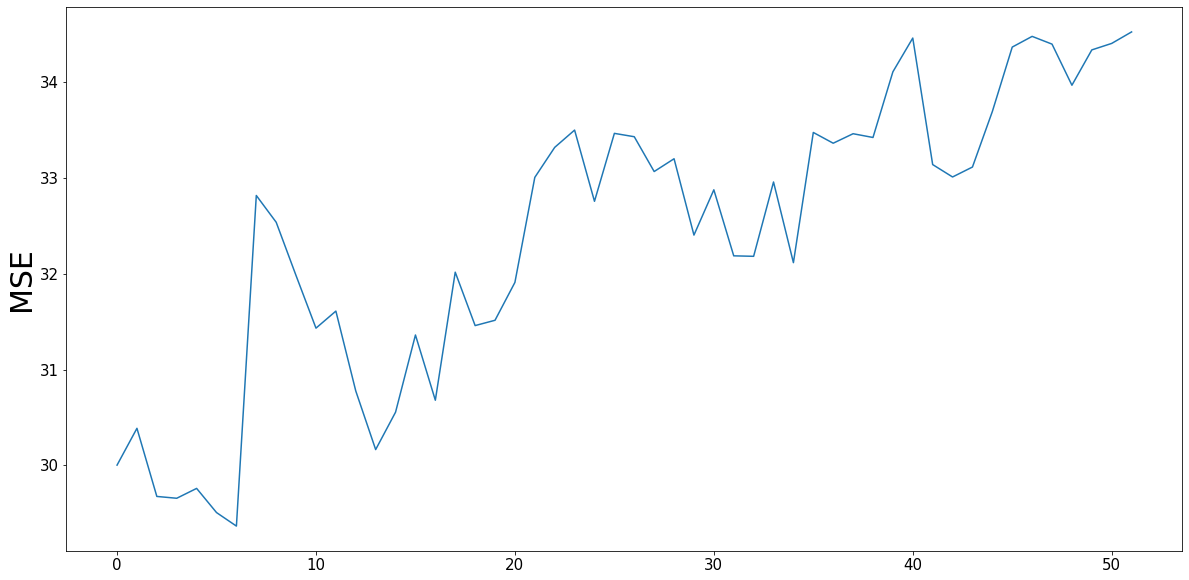

In [118]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [165]:
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]

I = np.array(diff) < 0 
#I = np.insert(I, 0, True)

#link = np.array(link_dict[0])[I,:]
link = link[I,:]
result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)

In [119]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
while not all(I):
    link_list.append(link)
    link = link[I,:]
    result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0

Text(0, 0.5, 'MSE')

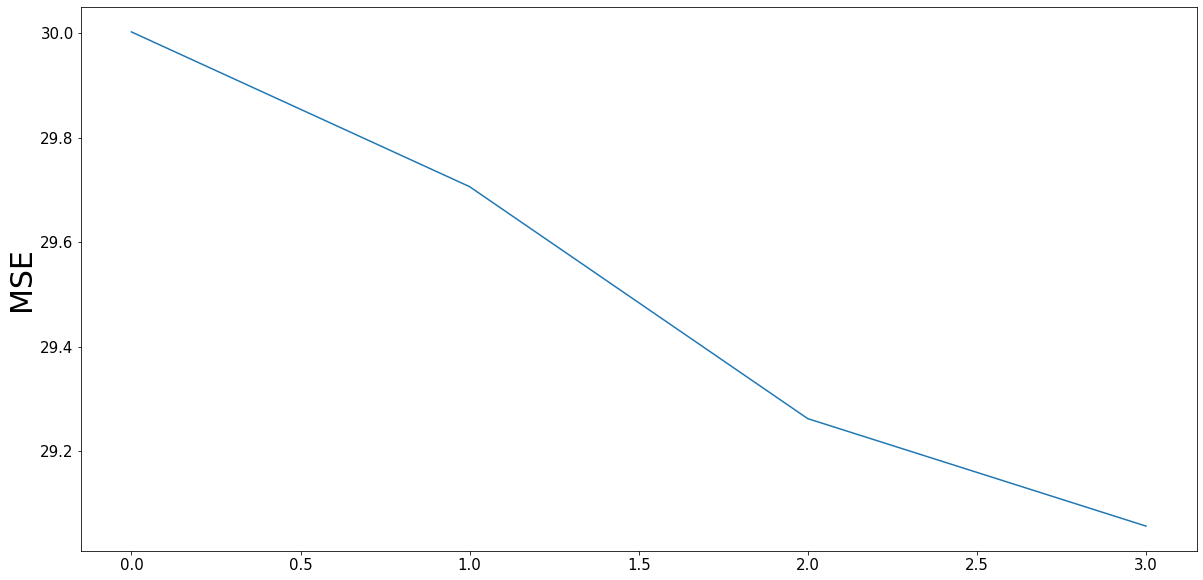

In [120]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [106]:
overall_min_MSE

[27.435002551894446,
 25.7228264541397,
 28.952951889030423,
 28.97155409067268,
 28.97155409067268,
 28.678338120623234,
 28.678338120623234]

In [121]:
overall_min_MSE

[29.366124196044925,
 29.024329087778487,
 27.361346883666247,
 28.559760923171222,
 29.26242131285778,
 29.056792424196633]

In [32]:
overall_min_MSE

[100.70233254234822,
 88.38443345429211,
 85.22158794640936,
 84.78961688925327,
 84.78961688925327]

In [122]:
index = np.where(np.array(overall_min_MSE) == np.array(overall_min_MSE).min())[0][-1]

In [123]:
best_links = link_list[index-1]

In [109]:
best_links

array([[  2, -12],
       [  0, -12],
       [ 41,  -1],
       [ 72, -11],
       [ 22,  -8],
       [ 52, -10],
       [ 18,  -3],
       [ 58,  -4],
       [ 46, -11],
       [ 38,  -8],
       [ 54,  -6],
       [ 52,  -2],
       [  0, -11],
       [ 14,  -6],
       [ 43, -11],
       [ 64,  -4],
       [  8, -12],
       [ 17,  -7],
       [ 29, -10],
       [ 68,  -2],
       [  5,  -8],
       [ 39, -10],
       [ 70,  -6],
       [ 67,  -9],
       [ 23,  -5],
       [ 66,  -1],
       [ 55,  -2],
       [ 50,  -2],
       [ 52,  -7],
       [ 38,  -2],
       [ 49,  -6],
       [ 67, -12],
       [ 75,  -4],
       [  1,  -4],
       [ 34, -11],
       [ 48, -10],
       [  6,  -5],
       [ 40,  -4],
       [ 10,  -7],
       [ 76,  -2],
       [ 33,  -8],
       [  0,  -2],
       [ 70,  -1],
       [ 57,  -6],
       [ 72,  -6],
       [  1, -10],
       [ 71,  -6],
       [ 67,  -6],
       [ 21,  -7],
       [ 14,  -3],
       [  2, -11]])

In [124]:
best_links

array([[ 10,  -7],
       [ 18,  -3],
       [ 48, -10],
       [ 72, -11],
       [  6,  -5],
       [ 34, -11],
       [ 70,  -6],
       [  2, -11],
       [ 39, -10],
       [ 49,  -6],
       [ 38,  -8],
       [  2, -12],
       [ 52,  -2],
       [ 67,  -6],
       [ 54,  -6],
       [ 14,  -6],
       [ 14,  -3],
       [  5,  -8],
       [ 76,  -2],
       [ 43, -11],
       [ 58,  -4],
       [ 71,  -6],
       [ 22,  -8],
       [ 55,  -2]])

In [172]:
for z in range(len(best_links)):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
 #   df = pd.DataFrame({"drought":count})

    for k in range(0,z+1):
            if best_links[k,0] != 0:
                df[str(best_links[k,0]-1)] = result_sst[:,best_links[k,0]-1]
                df[str(best_links[k,0]-1)] = df[str(best_links[k,0]-1)].shift(abs(best_links[k,1]))
            #else:
            #    df[str(best_links[k,0])] = count
            #    df[str(best_links[k,0])] = df[str(best_links[k,0])].shift(abs(best_links[k,1]))
df = df.dropna()
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [173]:
mean_squared_error(y_pred, y_test)

140.6447048928035

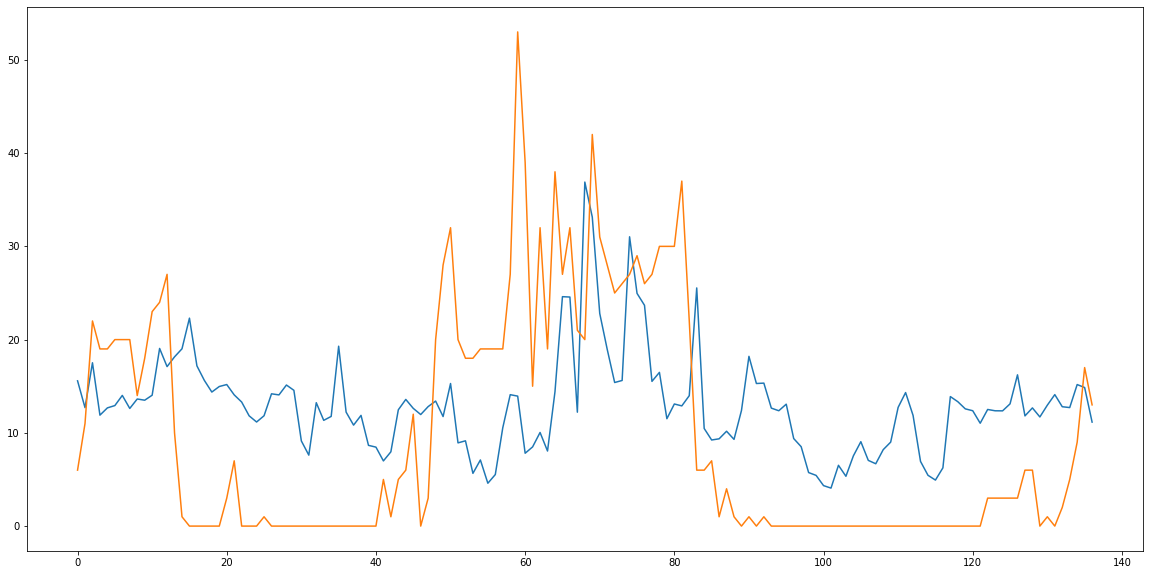

In [174]:
x = range(len(y_pred))

plt.plot(x,y_pred)
plt.plot(x,y_test)

In [175]:
n_components_sst = 76


sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_raw = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_raw))
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)


#scale = StandardScaler()
#scaled_data = scale.fit_transform(data_sst)

pca = PCA(n_components=n_components_sst)
pca_model = pca.fit(data_sst)
df_cluster_sst = pca_model.transform(data_sst)


#Matrix = pd.DataFrame(np.transpose(pca_model.components_))
#Matrix = (Matrix - Matrix.mean())/Matrix.std()
loading_sst = pf.varimax(np.transpose(pca_model.components_), q=1000)
for z in range(loading_sst.shape[1]):
    loading_sst[:,z] = loading_sst[:,z] / np.linalg.norm(loading_sst[:,z])
    
loading_sst = np.transpose(pca_model.components_) 
loading_sst = pd.DataFrame(loading_sst)

#Matrix = np.transpose(pca_model.components_)
#loading_sst = pd.DataFrame(pf.varimax(Matrix, q=1000))
#df_cluster_sst = np.matmul(np.array(data_sst), np.array(loading_sst))

clusters = loading_sst.idxmax(axis=1)
df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clusters.values.tolist()})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

In [176]:
def time_series_maker(pc, df_sst, result, level = 95): 
    limit = np.percentile(df_sst.pc.values, level)
    d = df_sst[df_sst.pc > limit]
    d = result[:,d.index].mean(axis=1)
    d = np.ravel(d)
    d = np.reshape(d,(len(d),1))
    d = pf.deseasonalize(d)
    d = np.ravel(d)
    return(d)

In [177]:
for z in range(len(best_links)):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(0,z+1):
            if best_links[k,0] != 0:
                pc = best_links[k,0]-1
                df_sst["pc"] = loading_sst[pc]  
                df[str(best_links[k,0]-1)] = time_series_maker(pc, df_sst, result_raw, 95)
                df[str(best_links[k,0]-1)] = df[str(best_links[k,0]-1)].shift(abs(best_links[k,1]))
            #else:
            #    df[str(best_links[k,0])] = count
            #    df[str(best_links[k,0])] = df[str(best_links[k,0])].shift(abs(best_links[k,1]))
df = df.dropna()
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [178]:
mean_squared_error(y_pred, y_test)

164.37648089589496

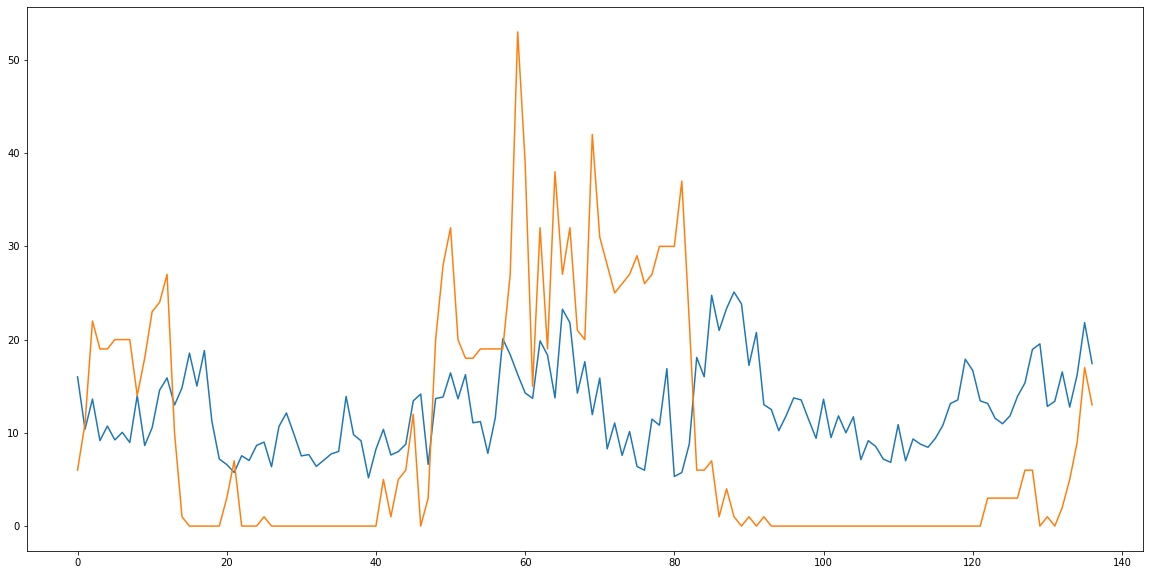

In [179]:
x = range(len(y_pred))

plt.plot(x,y_pred)
plt.plot(x,y_test)

In [404]:
name = ["../../nc/air.mon.mean.nc"]
code = ["air"]
missing = [-9.96921e+36]
n_components = [82]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result_sat = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result_sat))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[0]):
#    pres_name.append("PRES_%d"%i)

sat_name  = []
for i in range(n_components[0]):
    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sat_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sat = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sat), axis=1)
result = np.array(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_sat")

q_matrix = np.load("q_matrix_sat.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)




## Significant links at alpha = 0.05:

    Variable n_extremes has 52 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.501
        (SAT_22 -2): pval = 0.00021 | val = 0.223
        (SAT_59 -6): pval = 0.00041 | val = -0.215
        (SAT_64 -12): pval = 0.00160 | val = 0.196
        (SAT_38 -2): pval = 0.00368 | val = -0.179
        (SAT_52 -4): pval = 0.00398 | val = 0.178
        (SAT_13 -5): pval = 0.00572 | val = 0.174
        (SAT_62 -1): pval = 0.00624 | val = -0.169
        (SAT_63 -3): pval = 0.00815 | val = 0.162
        (SAT_80 -4): pval = 0.01095 | val = -0.160
        (SAT_14 -1): pval = 0.00861 | val = 0.160
        (SAT_29 -6): pval = 0.01090 | val = 0.159
        (SAT_49 -8): pval = 0.01192 | val = -0.155
        (SAT_66 -6): pval = 0.01544 | val = -0.152
        (SAT_35 -1): pval = 0.01409 | val = -0.152
        (SAT_52 -8): pval = 0.01579 | val = 0.151
        (SAT_55 -7): pval = 0.01798 | val = 0.148
        (SAT_24 -6): pval = 0.01680 | val = 0.146
        

In [405]:
pq_matrix = results['p_matrix']
val_matrix = results['val_matrix']
alpha_level = 0.05
N = pq_matrix.shape[0]

link_dict = dict()
for j in range(N):
    # Get the good links
    good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
    # Build a dictionary from these links to their values
    links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
             for i, tau in good_links}
    # Sort by value
    link_dict[j] = sorted(links, key=links.get, reverse=True)

link = np.array(link_dict[0])
link = link[1:,: ]

#np.random.shuffle(link)

#link[link[:,1]<=tau]

#np.random.shuffle(link[1:,:])

result, link = min_MSE_finder(count, result_sat, link,n_estimators, max_depth,tau)

overall_min_MSE = []
overall_min_MSE.append(min(result))

Text(0, 0.5, 'MSE')

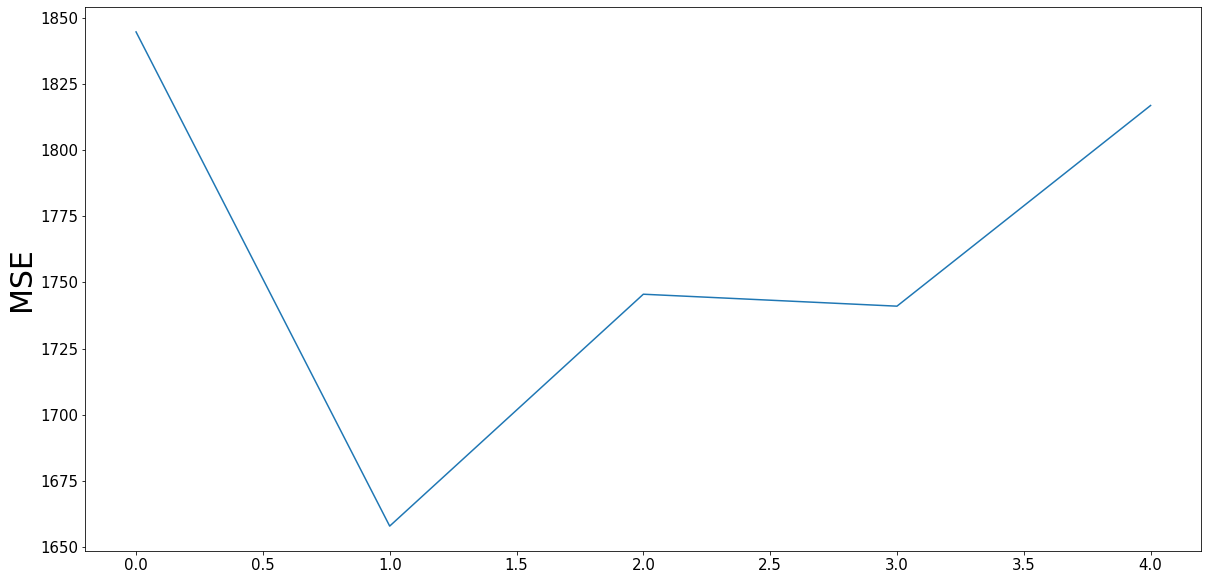

In [406]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [353]:
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]

I = np.array(diff) < 0 
#I = np.insert(I, 0, True)

#link = np.array(link_dict[0])[I,:]
link = link[I,:]
result, link = min_MSE_finder(count, result_sat, link,n_estimators, max_depth,tau)

In [407]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
while not all(I):
    link_list.append(link)
    link = link[I,:]
    result, link = min_MSE_finder(count, result_sat, link,n_estimators, max_depth,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0

Text(0, 0.5, 'MSE')

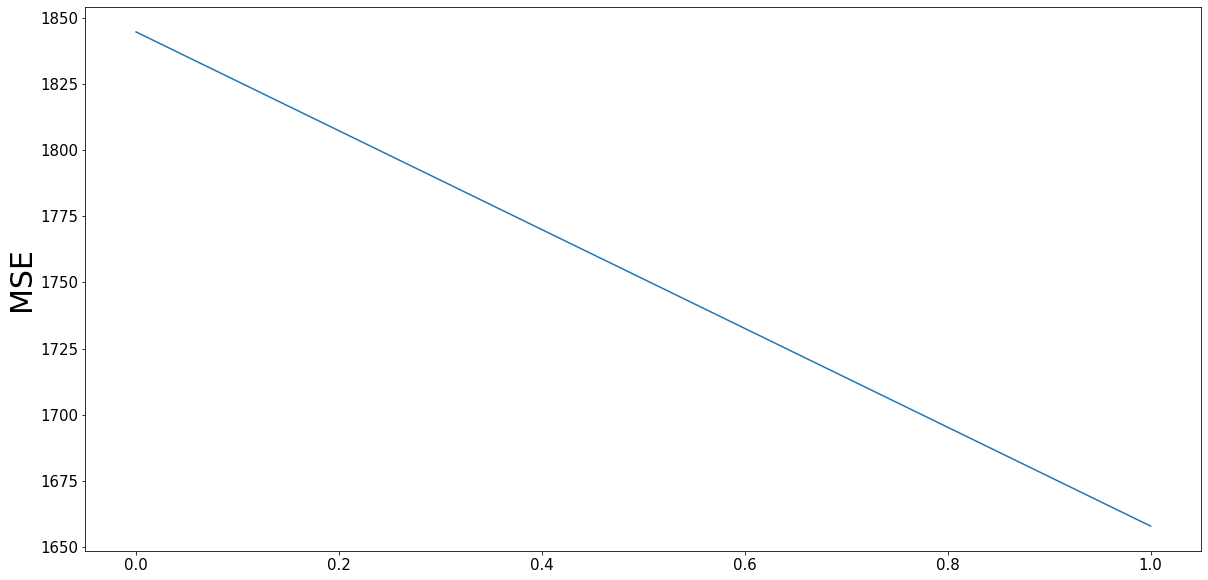

In [408]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [409]:
overall_min_MSE

[1657.8258044753884, 1657.8258044753884, 1657.8258044753884]

In [410]:
index = np.where(np.array(overall_min_MSE) == np.array(overall_min_MSE).min())[0][-1]

In [411]:
sat_links = link_list[index-1]

In [367]:
sat_links

array([[ 65, -12],
       [  0, -12]])

In [412]:
df_sat = pd.DataFrame()
for z in range(len(sat_links)):
    for k in range(0,z+1):
            if sat_links[k,0] != 0:
                df_sat[str(sat_links[k,0]-1)] = result_sat[:,sat_links[k,0]-1]
                df_sat[str(sat_links[k,0]-1)] = df_sat[str(sat_links[k,0]-1)].shift(abs(sat_links[k,1]))
            #else:
            #    df[str(sat_links[k,0])] = count
            #    df[str(sat_links[k,0])] = df[str(sat_links[k,0])].shift(abs(best_links[k,1]))
df_sat = df_sat.dropna()

In [413]:
df = np.array(df)

In [414]:
df_sat = np.array(df_sat)

In [415]:
df = np.concatenate((df,df_sat), axis = 1)

In [417]:
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df[:index,1:dim], df[index:,1:dim] 
y_train, y_test = df[:index,0], df[index:,0] 
model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [418]:
mean_squared_error(y_pred, y_test)

1719.1049450311991

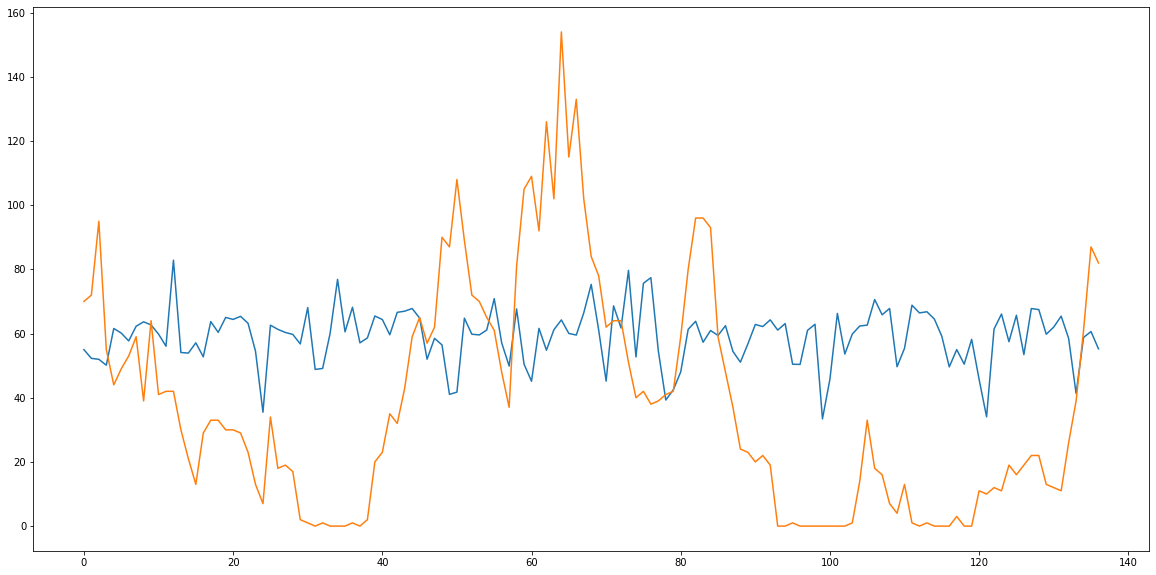

In [419]:
x = range(len(y_pred))

plt.plot(x,y_pred)
plt.plot(x,y_test)

# Second Approach

In [61]:
pq_matrix = results['p_matrix']
val_matrix = results['val_matrix']
alpha_level = 0.05
N = pq_matrix.shape[0]

link_dict = dict()
for j in range(N):
    # Get the good links
    good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
    # Build a dictionary from these links to their values
    links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
             for i, tau in good_links}
    # Sort by value
    link_dict[j] = sorted(links, key=links.get, reverse=True)


n_estimators=100
max_depth=100
tau = -6

In [62]:
link = np.array(link_dict[0])
link = link[1:,: ]

Text(0, 0.5, 'MSE')

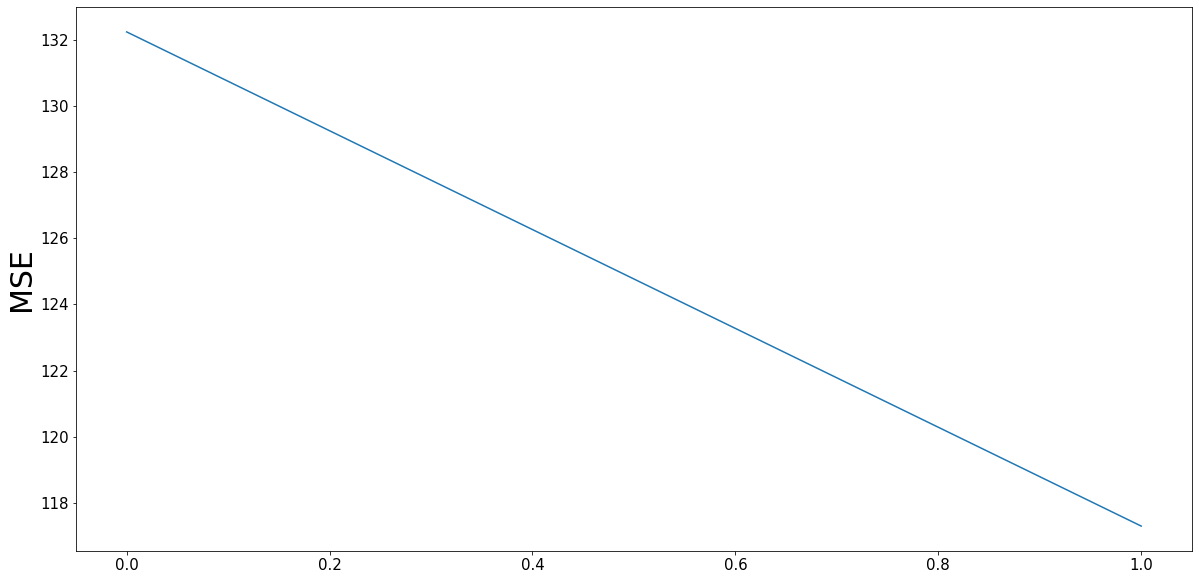

In [58]:
#np.random.shuffle(link[1:,:])

result, refined_link = min_MSE_finder1(count, result_sst, link,n_estimators, max_depth,tau)

overall_min_MSE = []
overall_min_MSE.append(min(result))

plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [60]:
min(result)

117.29212399305929

In [59]:
refined_link

array([[  2, -12]])

In [56]:
result

[1403.9484683246249,
 992.3122758008374,
 987.6159249495914,
 879.4992787013271,
 878.9826553311506,
 866.1072474052465,
 825.3225672676634,
 810.5792175855954,
 765.211163541713]

array([[  2, -12],
       [ 72, -11],
       [ 22,  -8],
       [ 38,  -8],
       [ 54,  -6],
       [ 14,  -6],
       [  5,  -8],
       [ 33,  -8]])

Text(0, 0.5, 'MSE')

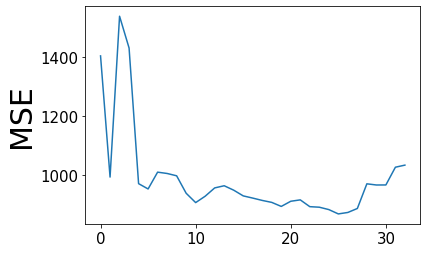

In [15]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [16]:
min(result)

867.1539408850756

In [41]:
np.array(refined_link)

array([[  2, -12],
       [ 72, -11],
       [ 22,  -8],
       [ 14,  -6],
       [  5,  -8],
       [ 33,  -8],
       [ 71,  -6]])

In [37]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
while not all(I):
    link_list.append(link)
    link = link[I,:]
    result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0 

Text(0, 0.5, 'MSE')

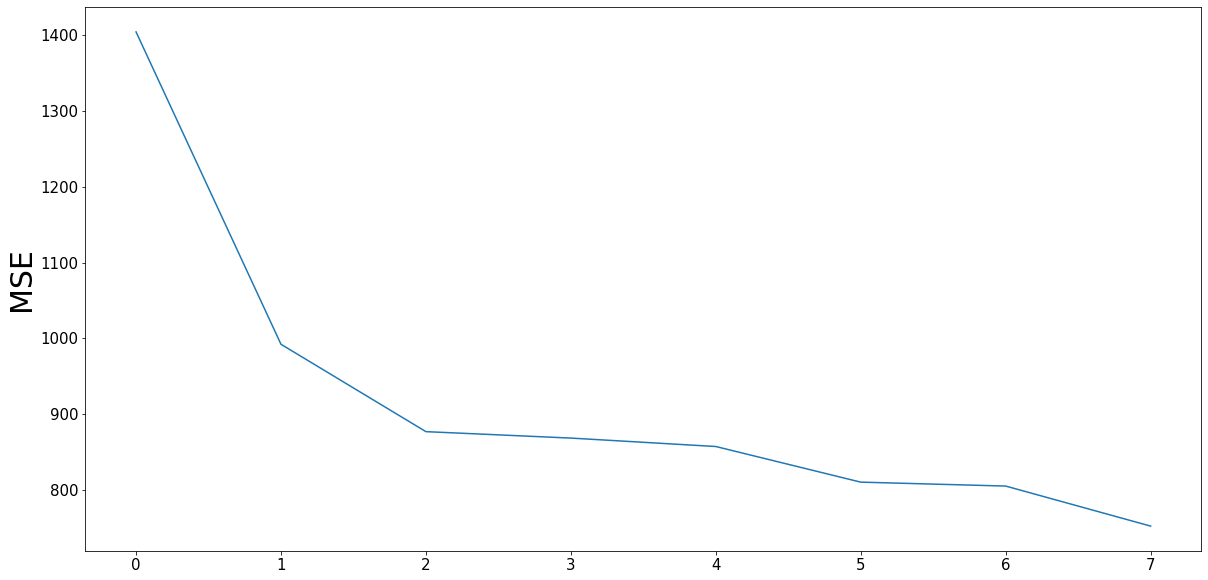

In [38]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [39]:
min(result)

752.7073589035881

In [40]:
overall_min_MSE

[887.7456114211551, 846.5992239394999, 797.4893528102945, 752.7073589035881]

Text(0, 0.5, 'MSE')

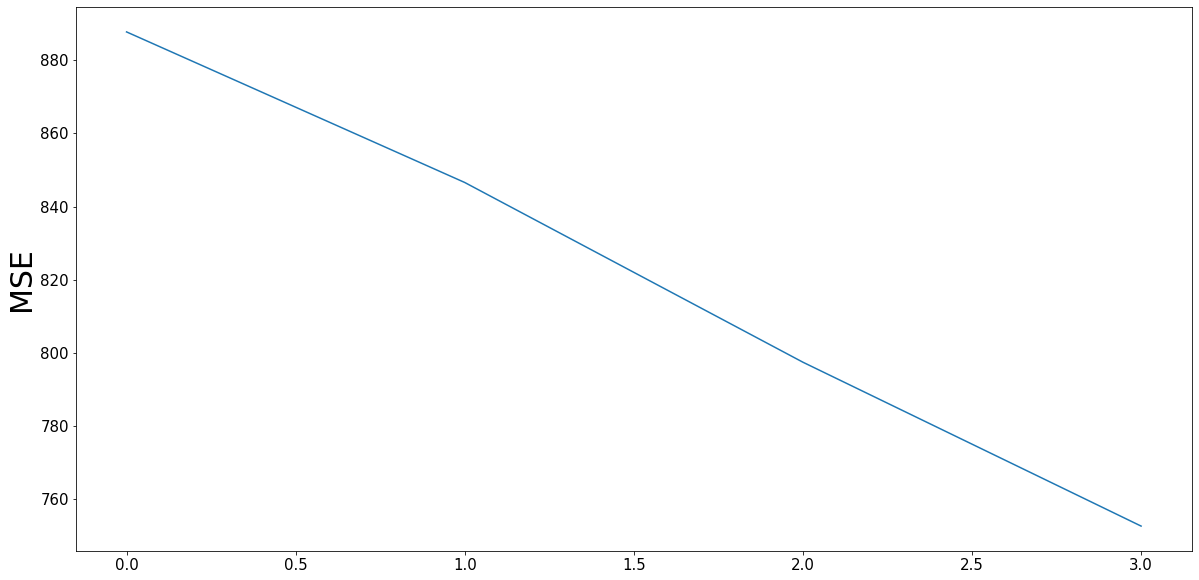

In [41]:
plt.plot(overall_min_MSE)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [42]:
link_list

[array([[  2, -12],
        [  0, -12],
        [ 72, -11],
        [ 22,  -8],
        [ 52, -10],
        [ 46, -11],
        [ 38,  -8],
        [ 54,  -6],
        [  0, -11],
        [ 14,  -6],
        [ 43, -11],
        [  8, -12],
        [ 17,  -7],
        [ 29, -10],
        [  5,  -8],
        [ 39, -10],
        [ 70,  -6],
        [ 67,  -9],
        [ 52,  -7],
        [ 49,  -6],
        [ 67, -12],
        [ 34, -11],
        [ 48, -10],
        [ 10,  -7],
        [ 33,  -8],
        [ 57,  -6],
        [ 72,  -6],
        [  1, -10],
        [ 71,  -6],
        [ 67,  -6],
        [ 21,  -7],
        [  2, -11]]), array([[  2, -12],
        [ 72, -11],
        [ 22,  -8],
        [ 52, -10],
        [ 38,  -8],
        [ 54,  -6],
        [  0, -11],
        [ 14,  -6],
        [ 29, -10],
        [  5,  -8],
        [ 39, -10],
        [ 70,  -6],
        [ 67,  -9],
        [ 52,  -7],
        [ 34, -11],
        [ 10,  -7],
        [ 33,  -8],
        [ 72,  -6],

In [22]:
link_list[3]

array([[  2, -12],
       [ 72, -11],
       [ 22,  -8],
       [ 38,  -8],
       [ 54,  -6],
       [ 14,  -6],
       [  5,  -8],
       [ 70,  -6],
       [ 33,  -8],
       [ 71,  -6]])

In [37]:
refined_link

[array([  2, -12]),
 array([ 72, -11]),
 array([22, -8]),
 array([14, -6]),
 array([ 5, -8]),
 array([33, -8]),
 array([71, -6])]

In [94]:
result =[]
tau = -6
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
df = df.dropna()
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
result.append(mean_squared_error(y_pred, y_test))

for z in range(1,len(link_dict[0])):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(1,z+1):
        if link_dict[0][k][1] <= tau:
            if link_dict[0][k][0] != 0 and link_dict[0][k][1] >= tau:
                df[str(link_dict[0][k][0]-1)] = result_sst[:,link_dict[0][k][0]-1]
                df[str(link_dict[0][k][0]-1)] = df[str(link_dict[0][k][0]-1)].shift(abs(link_dict[0][k][1]))
            else:
                df[str(link_dict[0][k][0])] = count
                df[str(link_dict[0][k][0])] = df[str(link_dict[0][k][0])].shift(abs(link_dict[0][k][1]))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]
    
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))

In [95]:
result

[1313.9073603912718,
 1311.4194559682414,
 1312.4432841387338,
 1312.4432841387338,
 1511.7432959280677,
 1497.3371557905002,
 1464.152396888303,
 1464.152396888303,
 1464.152396888303,
 1461.2927342714834,
 1475.5046532109288,
 1365.8259815568347,
 1365.8259815568347,
 1374.918484710145,
 1299.6950531599193,
 1287.0852062383813,
 1287.0852062383813,
 1296.204703816903,
 1295.5091182455192,
 1287.4078152307645,
 1287.4078152307645,
 1304.6673497970792,
 1295.0569970322526,
 1281.6032415124873,
 1290.67760570931,
 1290.67760570931,
 1290.67760570931,
 1290.67760570931,
 1290.67760570931,
 1286.3900736159271,
 1286.3900736159271,
 1273.5049326640114,
 1271.0798677971604,
 1271.0798677971604,
 1271.0798677971604,
 1263.127318383746,
 1269.7597639046576,
 1269.7597639046576,
 1269.7597639046576,
 1265.2645344184264,
 1265.2645344184264,
 1286.7779595802592,
 1286.7779595802592,
 1286.7779595802592,
 1242.106192429358,
 1245.7240740823531,
 1245.4913114257033,
 1131.7304163678307,
 1147.062

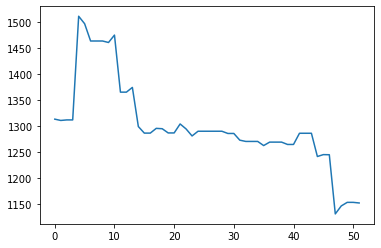

In [96]:
plt.plot(result)

In [116]:
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]

I = np.array(diff) < 0 
I = np.insert(I, 0, True)

#link = np.array(link_dict[0])[I,:]
link = link[I,:]

In [117]:
result =[]
tau = -6
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
df = df.dropna()
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
result.append(mean_squared_error(y_pred, y_test))

for z in range(1,len(link)):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(1,z+1):
        if link[k,0] != 0:
            df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
            df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
        else:
            df[str(link[k,0])] = count
            df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]
    
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))

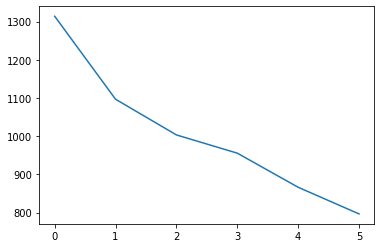

In [118]:
plt.plot(result)

In [119]:
link

array([[  0,  -1],
       [  2, -12],
       [ 22,  -8],
       [ 54,  -6],
       [ 14,  -6],
       [ 71,  -6]])

In [121]:
28/303

0.0924092409240924

In [23]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 2 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.354
        (SST_72 -8): pval = 0.00000 | qval = 0.00210 | val = -0.278

    Variable SST_0 has 2 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.565
        (SST_56 -5): pval = 0.00002 | qval = 0.02190 | val = -0.240

    Variable SST_1 has 2 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.581
        (SST_34 -10): pval = 0.00000 | qval = 0.00637 | val = 0.258

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.602

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.530

    Variable SST_4 has 1 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.523

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.503

    Variable SST_6 has 2 link(s):
     

In [36]:
name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc"]
code = ["precip"]
missing = [-9.96921e+36]
n_components = [87]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_pre = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_pre), axis=1)
result = np.array(result)

In [37]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [39]:
results = load_obj("results_pre")

q_matrix = np.load("q_matrix_pre.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 68 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.589
        (PRECIP_3 -1): pval = 0.00037 | val = -0.226
        (PRECIP_71 -6): pval = 0.00166 | val = 0.201
        (PRECIP_2 -1): pval = 0.00161 | val = -0.201
        (PRECIP_0 -1): pval = 0.00282 | val = -0.185
        (PRECIP_6 -1): pval = 0.00355 | val = -0.184
        (PRECIP_6 -8): pval = 0.00438 | val = -0.183
        (PRECIP_51 -11): pval = 0.00537 | val = -0.181
        (PRECIP_70 -1): pval = 0.00613 | val = -0.177
        (PRECIP_54 -5): pval = 0.00732 | val = 0.173
        (PRECIP_8 -6): pval = 0.00733 | val = -0.172
        (PRECIP_22 -7): pval = 0.00895 | val = 0.170
        (PRECIP_31 -5): pval = 0.00825 | val = -0.170
        (PRECIP_23 -2): pval = 0.00846 | val = -0.168
        (PRECIP_46 -11): pval = 0.01001 | val = -0.167
        (PRECIP_52 -3): pval = 0.01023 | val = 0.167
        (PRECIP_41 -7): pval = 0.01090 | val = -0.166
        (P

In [8]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.589

    Variable PRECIP_0 has 0 link(s):

    Variable PRECIP_1 has 0 link(s):

    Variable PRECIP_2 has 0 link(s):

    Variable PRECIP_3 has 0 link(s):

    Variable PRECIP_4 has 0 link(s):

    Variable PRECIP_5 has 0 link(s):

    Variable PRECIP_6 has 0 link(s):

    Variable PRECIP_7 has 0 link(s):

    Variable PRECIP_8 has 0 link(s):

    Variable PRECIP_9 has 0 link(s):

    Variable PRECIP_10 has 0 link(s):

    Variable PRECIP_11 has 0 link(s):

    Variable PRECIP_12 has 0 link(s):

    Variable PRECIP_13 has 0 link(s):

    Variable PRECIP_14 has 1 link(s):
        (PRECIP_86 -10): pval = 0.00000 | qval = 0.00601 | val = 0.345

    Variable PRECIP_15 has 0 link(s):

    Variable PRECIP_16 has 0 link(s):

    Variable PRECIP_17 has 0 link(s):

    Variable PRECIP_18 has 0 link(s):

    Variable PRECIP_19 has 0 link(s):

    Vari

In [12]:
name = ["../../nc/air.mon.mean.nc"]
code = ["air"]
missing = [-9.96921e+36]
n_components = [82]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[0]):
#    pres_name.append("PRES_%d"%i)

sat_name  = []
for i in range(n_components[0]):
    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sat_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sat = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sat), axis=1)
result = np.array(result)

In [13]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [14]:
results = load_obj("results_sat")

q_matrix = np.load("q_matrix_sat.npy")

In [15]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)




## Significant links at alpha = 0.05:

    Variable n_extremes has 52 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.501
        (SAT_22 -2): pval = 0.00021 | val = 0.223
        (SAT_59 -6): pval = 0.00041 | val = -0.215
        (SAT_64 -12): pval = 0.00160 | val = 0.196
        (SAT_38 -2): pval = 0.00368 | val = -0.179
        (SAT_52 -4): pval = 0.00398 | val = 0.178
        (SAT_13 -5): pval = 0.00572 | val = 0.174
        (SAT_62 -1): pval = 0.00624 | val = -0.169
        (SAT_63 -3): pval = 0.00815 | val = 0.162
        (SAT_80 -4): pval = 0.01095 | val = -0.160
        (SAT_14 -1): pval = 0.00861 | val = 0.160
        (SAT_29 -6): pval = 0.01090 | val = 0.159
        (SAT_49 -8): pval = 0.01192 | val = -0.155
        (SAT_66 -6): pval = 0.01544 | val = -0.152
        (SAT_35 -1): pval = 0.01409 | val = -0.152
        (SAT_52 -8): pval = 0.01579 | val = 0.151
        (SAT_55 -7): pval = 0.01798 | val = 0.148
        (SAT_24 -6): pval = 0.01680 | val = 0.146
        

In [10]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.501

    Variable SAT_0 has 1 link(s):
        (SAT_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.630

    Variable SAT_1 has 2 link(s):
        (SAT_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.475
        (SAT_43 -3): pval = 0.00000 | qval = 0.00403 | val = 0.298

    Variable SAT_2 has 1 link(s):
        (SAT_2 -1): pval = 0.00000 | qval = 0.01945 | val = 0.280

    Variable SAT_3 has 1 link(s):
        (SAT_3 -1): pval = 0.00000 | qval = 0.02694 | val = 0.282

    Variable SAT_4 has 0 link(s):

    Variable SAT_5 has 0 link(s):

    Variable SAT_6 has 1 link(s):
        (SAT_32 -4): pval = 0.00000 | qval = 0.03322 | val = 0.289

    Variable SAT_7 has 0 link(s):

    Variable SAT_8 has 0 link(s):

    Variable SAT_9 has 0 link(s):

    Variable SAT_10 has 0 link(s):

    Variable SAT_11 has 0 link(s):

    Variable SAT_12 has 0 lin

In [11]:
name = ["../../nc/pres.mon.mean.nc"]
code = ["pres"]
missing = [-9.96921e+36]
n_components = [64]


df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

pres_name  = []
for i in range(n_components[0]):
    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[0]):
#    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + pres_name

In [12]:
result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_pres = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_pres), axis=1)
result = np.array(result)

In [13]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [14]:
results = load_obj("results_pres")

q_matrix = np.load("q_matrix_pres.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 49 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.618
        (PRES_25 -10): pval = 0.00007 | val = 0.253
        (PRES_1 -1): pval = 0.00074 | val = -0.207
        (PRES_62 -7): pval = 0.00105 | val = -0.205
        (n_extremes -12): pval = 0.00117 | val = -0.204
        (PRES_11 -2): pval = 0.00265 | val = -0.190
        (PRES_49 -2): pval = 0.00303 | val = -0.178
        (PRES_5 -2): pval = 0.00638 | val = -0.169
        (PRES_24 -1): pval = 0.00653 | val = -0.169
        (PRES_58 -10): pval = 0.00729 | val = -0.169
        (PRES_50 -3): pval = 0.00516 | val = 0.169
        (PRES_57 -2): pval = 0.00686 | val = 0.167
        (PRES_41 -8): pval = 0.00776 | val = 0.166
        (PRES_61 -7): pval = 0.00835 | val = -0.164
        (PRES_62 -8): pval = 0.01142 | val = 0.160
        (PRES_37 -2): pval = 0.01456 | val = 0.153
        (PRES_61 -3): pval = 0.01320 | val = -0.152
        (PRES_49 -10): pval = 0.0134

In [15]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.618

    Variable PRES_0 has 0 link(s):

    Variable PRES_1 has 0 link(s):

    Variable PRES_2 has 0 link(s):

    Variable PRES_3 has 0 link(s):

    Variable PRES_4 has 0 link(s):

    Variable PRES_5 has 0 link(s):

    Variable PRES_6 has 1 link(s):
        (PRES_53 -9): pval = 0.00000 | qval = 0.01876 | val = -0.306

    Variable PRES_7 has 0 link(s):

    Variable PRES_8 has 0 link(s):

    Variable PRES_9 has 0 link(s):

    Variable PRES_10 has 0 link(s):

    Variable PRES_11 has 0 link(s):

    Variable PRES_12 has 0 link(s):

    Variable PRES_13 has 0 link(s):

    Variable PRES_14 has 0 link(s):

    Variable PRES_15 has 0 link(s):

    Variable PRES_16 has 0 link(s):

    Variable PRES_17 has 0 link(s):

    Variable PRES_18 has 0 link(s):

    Variable PRES_19 has 0 link(s):

    Variable PRES_20 has 0 link(s):

    Variable 

In [7]:
result_spi = np.load("df_cluster_spi.npy")

In [11]:


level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]
spi_components = 18

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sst_name
#

result_spi = np.array(result_spi)


In [12]:
result_sst = np.array(df_cluster[0])

result = np.concatenate((result_spi,result_sst), axis=1)
result = np.array(result)

In [13]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [15]:
results = load_obj("results_spi")

q_matrix = np.load("q_matrix_spi.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 77 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.588
        (SPI_0 -12): pval = 0.00000 | val = -0.334
        (SPI_2 -12): pval = 0.00000 | val = -0.268
        (SST_1 -7): pval = 0.00051 | val = -0.189
        (SST_1 -12): pval = 0.00061 | val = -0.187
        (SPI_2 -1): pval = 0.00087 | val = -0.184
        (SST_0 -10): pval = 0.00077 | val = 0.184
        (SPI_4 -2): pval = 0.00173 | val = 0.174
        (SST_18 -1): pval = 0.00308 | val = -0.167
        (SST_74 -4): pval = 0.00350 | val = -0.166
        (SST_45 -6): pval = 0.00469 | val = 0.163
        (SPI_2 -3): pval = 0.00405 | val = -0.159
        (SPI_16 -8): pval = 0.00427 | val = -0.159
        (SPI_9 -2): pval = 0.00459 | val = 0.158
        (SST_18 -7): pval = 0.00533 | val = -0.158
        (SPI_14 -9): pval = 0.00636 | val = -0.153
        (SPI_0 -11): pval = 0.00596 | val = 0.152
        (SPI_5 -9): pval = 0.00630 | val = 0.150
        (SST_34 -12):

In [16]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 3 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.588
        (SPI_0 -12): pval = 0.00000 | qval = 0.00000 | val = -0.334
        (SPI_2 -12): pval = 0.00000 | qval = 0.00181 | val = -0.268

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.608
        (SPI_1 -12): pval = 0.00000 | qval = 0.00008 | val = -0.298

    Variable SPI_2 has 3 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.618
        (SPI_2 -12): pval = 0.00000 | qval = 0.00457 | val = -0.259
        (SPI_0 -12): pval = 0.00000 | qval = 0.00430 | val = -0.258

    Variable SPI_3 has 5 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.597
        (SPI_3 -12): pval = 0.00000 | qval = 0.00000 | val = -0.417
        (SPI_4 -12): pval = 0.00000 | qval = 0.00003 | val = -0.313
        (SPI_15 -12): pval = 0.00003 | qval = 0.03400 | val = 0.234
        (SPI_

In [7]:
result_spi = np.load("df_cluster_spi.npy")

level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/air.mon.mean.nc"]
code = ["air"]
missing = [-9.96921e+36]
n_components = [82]
spi_components = 18

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

sat_name  = []
for i in range(n_components[0]):
    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sat_name
#

result_spi = np.array(result_spi)


In [9]:
result_sat = np.array(df_cluster[0])

result = np.concatenate((result_spi,result_sat), axis=1)
result = np.array(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_spi_sat")

q_matrix = np.load("q_matrix_spi_sat.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 89 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.617
        (SPI_0 -12): pval = 0.00001 | val = -0.268
        (SPI_2 -12): pval = 0.00005 | val = -0.239
        (SPI_5 -6): pval = 0.00037 | val = -0.208
        (SAT_52 -8): pval = 0.00120 | val = 0.201
        (SAT_40 -8): pval = 0.00121 | val = -0.198
        (SPI_4 -2): pval = 0.00107 | val = 0.193
        (SPI_1 -8): pval = 0.00153 | val = -0.188
        (SAT_38 -2): pval = 0.00202 | val = -0.185
        (SAT_39 -1): pval = 0.00192 | val = 0.183
        (SAT_8 -1): pval = 0.00235 | val = -0.182
        (SAT_33 -2): pval = 0.00353 | val = -0.180
        (SAT_78 -7): pval = 0.00437 | val = -0.173
        (SAT_68 -1): pval = 0.00440 | val = -0.171
        (SAT_22 -10): pval = 0.00615 | val = 0.166
        (SAT_11 -1): pval = 0.00548 | val = -0.166
        (SPI_1 -6): pval = 0.00605 | val = -0.163
        (SAT_49 -12): pval = 0.00757 | val = 0.161
        (SPI_17 -

In [10]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 2 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.617
        (SPI_0 -12): pval = 0.00001 | qval = 0.02026 | val = -0.268

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.608
        (SPI_1 -12): pval = 0.00000 | qval = 0.00735 | val = -0.285

    Variable SPI_2 has 3 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.618
        (SPI_2 -12): pval = 0.00001 | qval = 0.04145 | val = -0.253
        (SPI_0 -12): pval = 0.00002 | qval = 0.04868 | val = -0.250

    Variable SPI_3 has 2 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.603
        (SPI_3 -12): pval = 0.00000 | qval = 0.00003 | val = -0.341

    Variable SPI_4 has 2 link(s):
        (SPI_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.600
        (SPI_4 -12): pval = 0.00000 | qval = 0.00005 | val = -0.332

    Variable SPI_5 has 1 link(s):
        (SPI_

In [10]:
result_spi = np.load("df_cluster_spi_global.npy")

In [14]:
level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]
spi_components = 46

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sst_name
#

result_spi = np.array(result_spi)


In [15]:
result_sst = np.array(df_cluster[0])

result = np.concatenate((result_spi,result_sst), axis=1)
result = np.array(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [16]:
results = load_obj("results_SPI_global")

q_matrix = np.load("q_matrix_SPI_global.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 95 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.678
        (SPI_0 -12): pval = 0.00000 | val = -0.306
        (SST_34 -5): pval = 0.00020 | val = -0.207
        (SST_73 -10): pval = 0.00036 | val = 0.196
        (SST_1 -1): pval = 0.00057 | val = 0.185
        (SPI_28 -12): pval = 0.00094 | val = 0.181
        (SST_52 -4): pval = 0.00195 | val = -0.171
        (SPI_41 -7): pval = 0.00243 | val = 0.165
        (SST_4 -7): pval = 0.00327 | val = -0.162
        (SST_64 -2): pval = 0.00449 | val = -0.157
        (SPI_37 -8): pval = 0.00503 | val = 0.152
        (SST_46 -1): pval = 0.00627 | val = -0.151
        (SPI_30 -2): pval = 0.00557 | val = 0.150
        (SPI_33 -11): pval = 0.00560 | val = 0.150
        (SST_11 -8): pval = 0.00729 | val = -0.149
        (SPI_19 -4): pval = 0.00596 | val = 0.148
        (SPI_18 -6): pval = 0.00616 | val = 0.147
        (SPI_34 -12): pval = 0.00673 | val = 0.147
        (SST_64 -

In [17]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 2 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.678
        (SPI_0 -12): pval = 0.00000 | qval = 0.00001 | val = -0.306

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.649
        (SPI_1 -12): pval = 0.00000 | qval = 0.00029 | val = -0.275

    Variable SPI_2 has 4 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.661
        (SPI_2 -12): pval = 0.00000 | qval = 0.00001 | val = -0.315
        (SPI_12 -3): pval = 0.00001 | qval = 0.01597 | val = 0.242
        (SPI_36 -12): pval = 0.00003 | qval = 0.02910 | val = 0.227

    Variable SPI_3 has 2 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.634
        (SPI_3 -12): pval = 0.00005 | qval = 0.04797 | val = -0.226

    Variable SPI_4 has 2 link(s):
        (SPI_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.647
        (SPI_4 -12): pval = 0.00000 | qval = 0.00